In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNetCV
import numpy as np

In [38]:
df = pd.read_json('data/feature_extracted.ndjson', lines=True)
df = df.fillna(0)

In [39]:
df.head(2)

,result,moves,white_elo,black_elo,ECO,Opening,white_cpl,black_cpl,total_moves,end_r,...,end_N,end_R,end_Q,end_K,queen_moved_at,total_checks,first_check_at,queen_changed_at,promotion,can_claim_draw
0,1/2-1/2,"[e2e4, e7e5, g1f3, g8f6, d2d4, f6e4, f3e5, d7d...",2523,2460,C42,Petrov,"[-11, 81, -20, 3]","[78, -7, -6]",7,2.0,...,2.0,2.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1,0-1,"[e2e4, d7d5, e4d5, g8f6, d2d4, f6d5, g1f3, g7g...",1915,1999,B01,Scandinavian,"[20, 0, 17, 28, 28, 92, 10, 9, -1, 5, -1, 16, ...","[25, -4, -13, 8, 34, 21, 31, 2, 11, 0, -5, 8, ...",53,1.0,...,0.0,1.0,0.0,1,13.0,8.0,13.0,16.0,0.0,0.0


In [40]:
df["ECO"] = df["ECO"].astype('category')
df["Opening"] = df["Opening"].astype('category')
df["result"] = df["result"].astype('category')

df["mean_elos"] = df[['white_elo', 'black_elo']].mean(axis=1)
df["diff_elos"]= df['white_elo'] - df['black_elo']

In [41]:
print(len(df))
df = df[df['white_cpl'].apply(lambda x: len(x) > 0)]
df = df[df['black_cpl'].apply(lambda x: len(x) > 0)]
print(len(df))

2400
2395


In [42]:
df['white_mean'] = df['white_cpl'].apply(np.mean)
df['white_std'] = df['white_cpl'].apply(np.std)
df['white_min'] = df['white_cpl'].apply(np.min)
df['white_max'] = df['white_cpl'].apply(np.max)

df['black_mean'] = df['black_cpl'].apply(np.mean)
df['black_std'] = df['black_cpl'].apply(np.std)
df['black_min'] = df['black_cpl'].apply(np.min)
df['black_max'] = df['black_cpl'].apply(np.max)

In [17]:
df.head(2)

,result,moves,white_elo,black_elo,ECO,Opening,white_cpl,black_cpl,total_moves,end_r,...,mean_elos,diff_elos,white_mean,white_std,white_min,white_max,black_mean,black_std,black_min,black_max
0,1/2-1/2,"[e2e4, e7e5, g1f3, g8f6, d2d4, f6e4, f3e5, d7d...",2523,2460,C42,Petrov,"[-11, 81, -20, 3]","[78, -7, -6]",7,2.0,...,2491.5,63,13.25,39.964828,-20,81,21.666667,39.835774,-7,78
1,0-1,"[e2e4, d7d5, e4d5, g8f6, d2d4, f6d5, g1f3, g7g...",1915,1999,B01,Scandinavian,"[20, 0, 17, 28, 28, 92, 10, 9, -1, 5, -1, 16, ...","[25, -4, -13, 8, 34, 21, 31, 2, 11, 0, -5, 8, ...",53,1.0,...,1957.0,-84,36.22,71.202329,-48,430,23.940000,42.293929,-39,162


In [43]:
results = pd.get_dummies(df['result'])
ecos = pd.get_dummies(df["ECO"])

In [44]:
to_drop = ["white_elo", "black_elo", "diff_elos", "mean_elos", "diff_elos", "moves", "ECO", "Opening", "black_cpl", "white_cpl", "result"]

# Assuming 'target' is the name of the column you want to predict
features = df.drop(to_drop, axis=1)
X = pd.concat([features, ecos, results], axis=1)
y = df['mean_elos']


In [20]:
features.head(2)

,total_moves,end_r,end_n,end_b,end_q,end_k,end_p,end_P,end_B,end_N,...,promotion,can_claim_draw,white_mean,white_std,white_min,white_max,black_mean,black_std,black_min,black_max
0,7,2.0,2.0,2.0,1.0,1,7.0,7.0,2.0,2.0,...,0.0,0.0,13.25,39.964828,-20,81,21.666667,39.835774,-7,78
1,53,1.0,0.0,0.0,0.0,1,3.0,2.0,0.0,0.0,...,0.0,0.0,36.22,71.202329,-48,430,23.940000,42.293929,-39,162


In [45]:
num_estims = [50, 100, 200, 300, 400, 500, 600]

maes = []

for n in num_estims:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Initialize the model
    model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    maes.append(mae)
    

In [46]:
for i in range(len(maes)):
    print(f"Number of Estimators: {num_estims[i]}. Mean Absolute Error: {maes[i]}")

Number of Estimators: 50. Mean Absolute Error: 174.23651009046625
Number of Estimators: 100. Mean Absolute Error: 173.5927366040362
Number of Estimators: 200. Mean Absolute Error: 171.36100661099513
Number of Estimators: 300. Mean Absolute Error: 172.019537230341
Number of Estimators: 400. Mean Absolute Error: 177.64957724425886
Number of Estimators: 500. Mean Absolute Error: 176.74216910229643
Number of Estimators: 600. Mean Absolute Error: 167.50752313848298


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Initialize the model
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
maes.append(mae)

251.85704


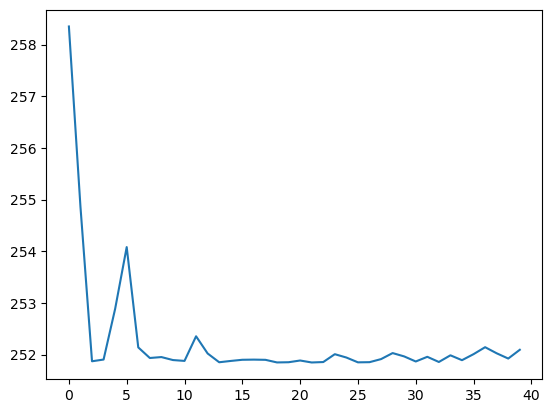

In [32]:

import matplotlib.pyplot as plt
import math


def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

print(r_mse(y_pred.mean(0), y_test))


plt.plot([r_mse(y_pred[:i+1].mean(0), y_test) for i in range(40)])

### Feature Importance

In [35]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [48]:

fi = rf_feat_importance(model, X_test)
fi[:10]

,cols,imp
23,black_mean,0.155054
19,white_mean,0.124339
20,white_std,0.052333
22,white_max,0.050106
24,black_std,0.047465
26,black_max,0.045919
21,white_min,0.045391
25,black_min,0.042574
13,queen_moved_at,0.038848
0,total_moves,0.035295


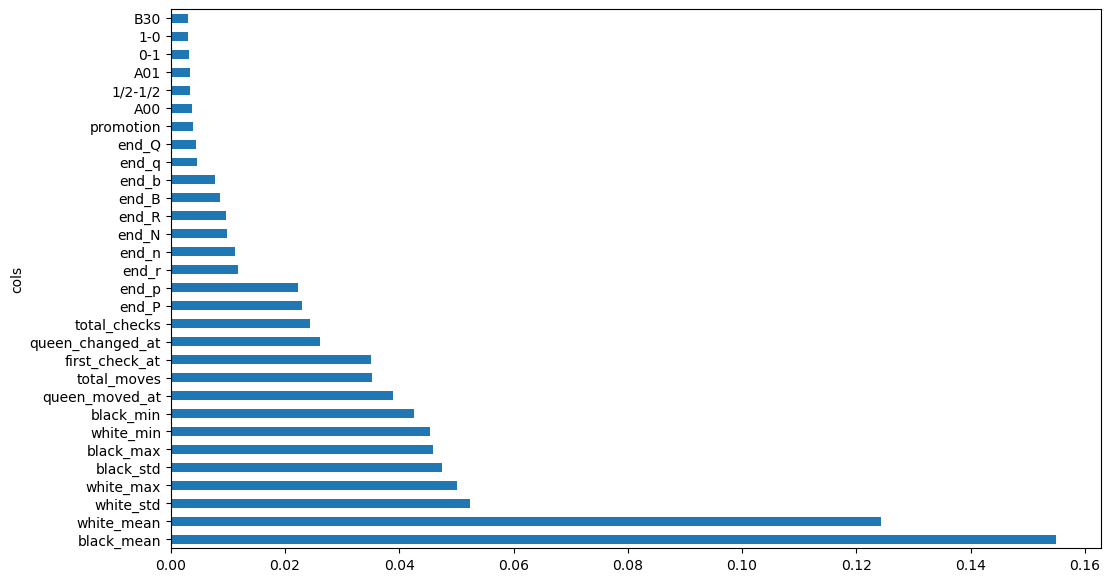

In [49]:

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error')

In [24]:
# Best parameters
best_params = grid_search.best_params_
print(f"Best n_estimators: {best_params['n_estimators']}")

# Best model
best_rf = grid_search.best_estimator_

Best n_estimators: 100


In [25]:
# Make predictions with the best model
y_pred = best_rf.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with the best model: {mse}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error with the best model: {mae}')

Mean Squared Error with the best model: 48843.06967633294
Mean Absolute Error with the best model: 178.38083211551844


249.40203

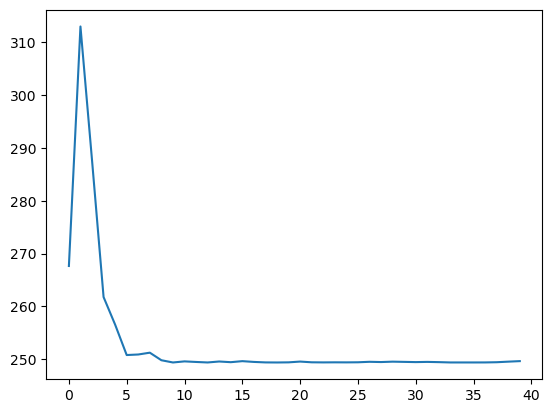

In [28]:
r_mse(best_rf.oob_prediction_, y)

AttributeError: 'RandomForestRegressor' object has no attribute 'oob_prediction_'